# PHYSICS 3G03 HW 1: Optimization, coordinate descent {-}
## Matthew Bain (001406931) {-}

We start by importing all the Python libraries we will need for this project.

In [25]:
# import dependencies
import numpy as np               # numpy for vectorization functionality etc.
import numpy.linalg as LA        # linalg module of numpy for efficient vector/matrix computations
import matplotlib.pyplot as plt  # pyplot module of matplotlib for plotting

## **Exercise 1** *Random search and the Rosenbrock Banana function* {-}

**1.1** In this exercise we implement the `random_search` function that was started for us.

The random search algorithm is one approach to minimizing a cost function, `g`. A cost function usually represents the performance of a model we've built to understand or make predictions about a dataset. The parameter `w` is a vector of values (representing a point in the input space of `g`) with respect to which we minimize `g`. Random search randomly generates `num_samples` different directions from a point `w`, and travels in the direction that reduces the value of `g` the most, with a step length of `alpha`.

*Exercise notes: treat `w` as the starting point. Store all candidate directions in `directions` and corresponding weights in `w_candidates`. Evaluate the cost function at all `w_candidates`.*

### Implementing random search {-}

What we're given:

In [26]:
# random search function -- starting point
def random_search(g, alpha_choice, max_its, w, num_samples):
    # run random search
    w_history = []      # container for w history
    cost_history = []   # container for corresponding cost function history
    alpha = 0
    for k in range(1, max_its+1):
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(k)
        else:
            alpha = alpha_choice

    return w_history,cost_history

We expand the above according to the following notes:

- Starting from `w`, we generate `num_samples` potential directions and store them in `directions`
  - Each direction is an $n$-dimensional vector, where $n$ corresponds to the length of `w` (i.e., the dimension of the input space).
  - We randomly sample each component of each vector from the standard normal distribution, $N(0,1)$, -- i.e., a distribution centered at 0, with ~2/3 of values falling between -1 and 1. 
  - Randomly sampling component values from the normal distribution, as opposed to from the uniform distribution on the interval $[-1, 1]$, is, somewhat counterintuitively, the approach that is least biased (i.e., yields the 'most random' directions). 
  - We could also sample angles $\theta$ between $[0, 2\pi]$ and treat our (unit) vector as the corresponding direction $[\cos(\theta), \sin(\theta)]$. This is perfectly natural in two dimensions but doesn't generalize as well to higher dimensions. More on methods for choosing a unit vector in this article: [The Best Way to Pick a Unit Vector - Don Cross, Toward Data Science](https://towardsdatascience.com/the-best-way-to-pick-a-unit-vector-7bd0cc54f9b).

<break>

- Next we normalize each direction vector, and, scaling by `alpha`, add them to `w` (i.e., 'take a step' in each direction), storing the results in `w_candidates`.
- We then evaluate `g` at each candidate `w` and select the one that yields the lowest value (i.e., the greatest cost decrease).
- This gives us our new value of `w`, which we store in `w_history`. We store the corresponding cost in `cost_history`.
- We iterate this process `max_its` times, or until our randomly generated directions fail to yield a candidate `w` that decreases `g`.

The implementation:

In [27]:
# random search
def random_search(g, alpha_choice, max_its, w, num_samples, **kwargs):
    
    # optional (keyword) arguments
    # vec = kwargs.get('vec', 1)
    
    # run random search
    w_history = []      # container for w history
    cost_history = []   # container for corresponding cost function history

    # store initial values of 'w' and 'g'
    w_history.append(list(w))
    cost_history.append(g(w))
  
    alpha = 0
    for it in range(1, max_its+1):
        
        # seed the random number generator
        np.random.seed(19680801)

        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(it) # in diminishing case we make step length inversely proportional to iteration
        else:
            alpha = alpha_choice # in the case that alpha is a constant
        
        ## generate random directions
        # generate random directions (represent as array of 'num_samples' vectors of length determined by w)
        directions = np.random.randn(len(w), num_samples)

        # compute vector lengths column-wise (returns 1 x 'num_samples' array)
        directions_len = LA.norm(directions, axis = 0) 

        # normalize directions by vector-wise division by elements in 'directions_len'
        directions = directions/directions_len 
    
        ## find direction that minimizes cost function
        # starting from 'w', "take a step" in each 'candidate direction'
        w_candidates = ((directions.T)*alpha + w).T # transpose 'directions' to add each to w

        # use 'map' to convert candidate points to list of vectors to easily evaluate g over all candidates
        w_candidates = map(list, w_candidates.T) 
        w_candidates = list(w_candidates)

        ## evaluate cost function at each candidate point (most compact/efficient method I can think of...)
        g_candidates = np.array([g(np.array(wi)) for wi in w_candidates]) 

        min_ix = np.argmin(g_candidates) # identify index of argument (direction) that minimizes cost 
        g_min = g_candidates[min_ix]

        ## store new values
        # if iteration 1 or new w reduces g, overwrite 'w' and store g; else stay in place
        if (it == 1) or ( g_min < cost_history[-1] ):
            w = w_candidates[min_ix]
            w_history.append(w)
            cost_history.append(g_min)
        else:
            # store old 'w' and 'g' again
            w_history.append(w)
            cost_history.append(cost_history[-1])

    return w_history, cost_history

**1.2** In this exercise we put our implementation of `random_search` to the test with an example. 

### Testing `random_search` {-}

In [28]:
# our example cost function (defined concisely in python using a lambda function) 
g = lambda w: np.dot(w.T,w) + 2
alpha_choice = 1; w = np.array([3,4]); num_samples = 1000; max_its = 5 # choices of parameters

# run algorithm
w_history, cost_history = random_search(g, alpha_choice, max_its, w, num_samples)

Below we plot `w_history` (each point in 3-space):

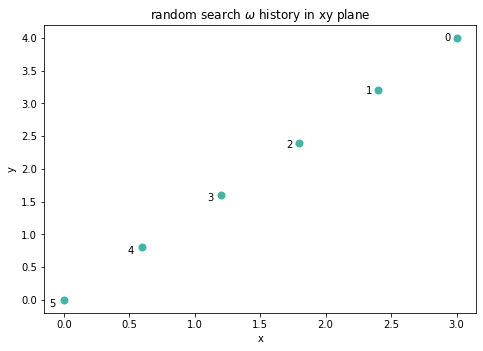

In [29]:
## define general plotting parameters
plt_clrs = (np.array([94,255,231])/360, np.array([133,94,214])/360, np.array([110,250,152])/360)

## plot 'w_history'
# setup data (using Python list comprehension)
x = [item[0] for item in w_history] # store all 'x' coordinates of points
y = [item[1] for item in w_history] # store all 'y' coordinates of points

# setup plot
fig = plt.figure(figsize = (6, 4), frameon = 0)
ax = fig.add_axes([0, 0, 1, 1])

# plot scatter in the xy plane
ax.scatter(x, y, color = plt_clrs[0], linewidth = 2)

# label points
for w in range(0, len(w_history), 1):
    ax.annotate(str(w), xy = (x[w], y[w]), xytext = (x[w]-15, y[w]-7), textcoords = 'offset points')

# axis/figure labels
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.title('random search $\omega$ history in xy plane')

# output figure
plt.show()


Each point is labelled with the iteration of `random_search` to which it corresponds. Initial value is labelled as '0'. 

Notice that the cost function has a global minimum at $\omega = (0,0)$, which `w` appears to be steadily approaching with each iteration of `random_search`.

Below we plot `cost_history` as a function of random search iteration. 

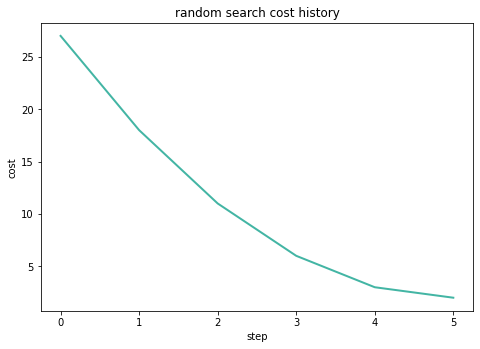

In [30]:
## plot 'w_history'
# setup data (using Python list comprehension)
x = range(0, len(w_history), 1)
y = cost_history # store all 'y' coordinates of points

# setup plot
fig = plt.figure(figsize = (6, 4), frameon = 0)
ax = fig.add_axes([0, 0, 1, 1])

# plot scatter in the xy plane
ax.plot(x, y, color = plt_clrs[0], linewidth = 2)

# axis/figure labels
ax.set_xlabel('step')
ax.set_ylabel('cost')
plt.title('random search cost history')

# output figure
plt.show()

Notice that the global minimum of the cost function $g(0,0)$ occurs at a value of 2, to which `cost_history` appears be converging.

Based on these findings we can conclude that `random_search` performs reasonably well under these fairly uncomplicated circumstances.

**1.3** Now we explore how step length affects the effectiveness of the random search algorithm.

### Experimenting with step length {-}

Below we repeat the analysis above for a step length of `alpha` = 0.3.

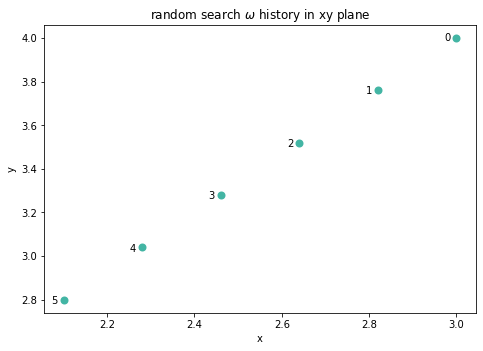

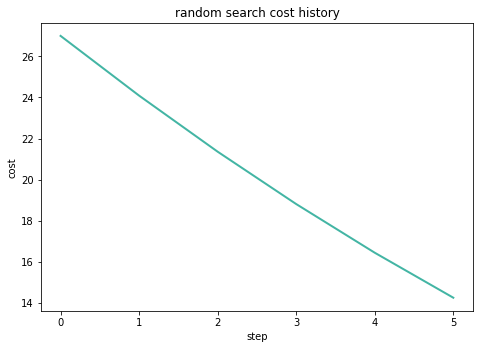

In [31]:
g = lambda w: np.dot(w.T,w) + 2
alpha_choice = .3; w = np.array([3,4]); num_samples = 1000; max_its = 5
w_history, cost_history = random_search(g, alpha_choice, max_its, w, num_samples)

## plot 'w_history'
x = [item[0] for item in w_history] # store all 'x' coordinates of points
y = [item[1] for item in w_history] # store all 'y' coordinates of points

fig = plt.figure(figsize = (6, 4), frameon = 0)
ax = fig.add_axes([0, 0, 1, 1])

ax.scatter(x, y, color = plt_clrs[0], linewidth = 2)

for w in range(0, len(w_history), 1):
    ax.annotate(str(w), xy = (x[w], y[w]), xytext = (x[w]-15, y[w]-7), textcoords = 'offset points')

ax.set_xlabel('x')
ax.set_ylabel('y')
plt.title('random search $\omega$ history in xy plane')

plt.show()

## plot 'cost_history'
x = range(0, len(w_history), 1)
y = cost_history

fig = plt.figure(figsize = (6, 4), frameon = 0)
ax = fig.add_axes([0, 0, 1, 1])

ax.plot(x, y, color = plt_clrs[0], linewidth = 2)

ax.set_xlabel('step')
ax.set_ylabel('cost')
plt.title('random search cost history')

plt.show()

Notice that using a step length of .3 as opposed to 1, as before, `random_search` appears to be approaching the global minimum. However, whereas with a larger step length the algorithm managed to successfully approximate the minimum in 5 iterations, in the above case `w` fails to converge to the minimum within the same 5 iterations.

**1.4** Now we experiment with higher-dimensional cost functions and different step length rules.

Below we define The Rosenbrock Banana function and run `random_search` with two sets of parameters, the first with a constant and the second a diminishing step length.

In [32]:
# define cost function
# g = lambda w1, w2: 100 * ((w2 - w1**2))**2 + (w1 - 1)**2
g = lambda w: 100 * ((w[1] - w[0]**2)**2) + (w[0] - 1)**2

# set random search parameters
w = [-2, -2]; num_samples = 1000; max_its = 50

# case 1: constant step length
alpha_choice = 1
w_history_case1, cost_history_case1 = random_search(g, alpha_choice, max_its, w, num_samples)

# case 2: decreasing step length
alpha_choice = 'diminishing'
w_history_case2, cost_history_case2 = random_search(g, alpha_choice, max_its, w, num_samples)

Below we plot the corresponding cost history for each case.

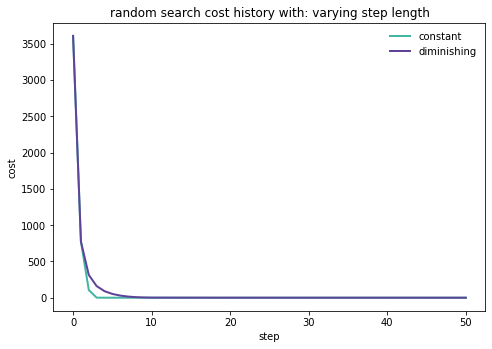

In [33]:
## plot 'cost_history'
# store data
x_case1 = range(0, len(w_history_case1), 1)
x_case2 = range(0, len(w_history_case2), 1)
y_case1 = cost_history_case1
y_case2 = cost_history_case2

# setup plot
fig = plt.figure(figsize = (6, 4), frameon = 0)
ax = fig.add_axes([0, 0, 1, 1])

# plot
line_case1 = ax.plot(x_case1, y_case1, color = plt_clrs[0], linewidth = 2)
line_case2 = ax.plot(x_case2, y_case2, color = plt_clrs[1], linewidth = 2)

# add labels
ax.set_xlabel('step')
ax.set_ylabel('cost')
plt.title('random search cost history with: varying step length')

# plot legend
labels = ['constant', 'diminishing']
ax.plot(box = 0)
ax.legend([line_case1, line_case2], labels = ['constant', 'diminishing'], frameon = 0)

plt.show()

Now we visualize the trajectory of `w_history` over a contour plot of the cost function -- providing a 2-dimensional representation of how the 'position vector' moved around the cost function in its search for a minimum. The `static_plotter` function is from the *Machine Learning Refined* repository [(Watt, 2020)](https://github.com/jermwatt/machine_learning_refined).

case 1: constant step length


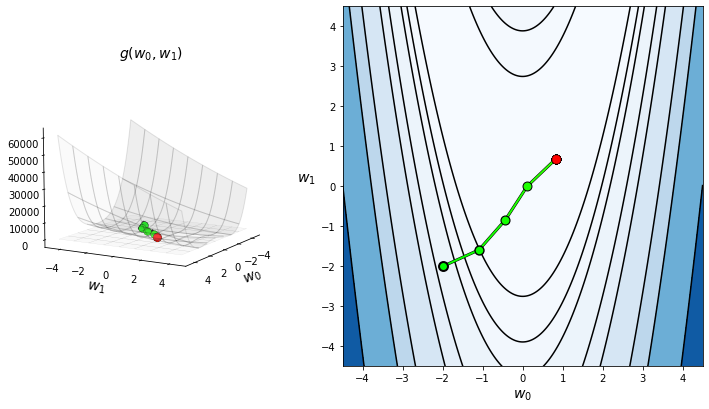

case 2: diminishing step length


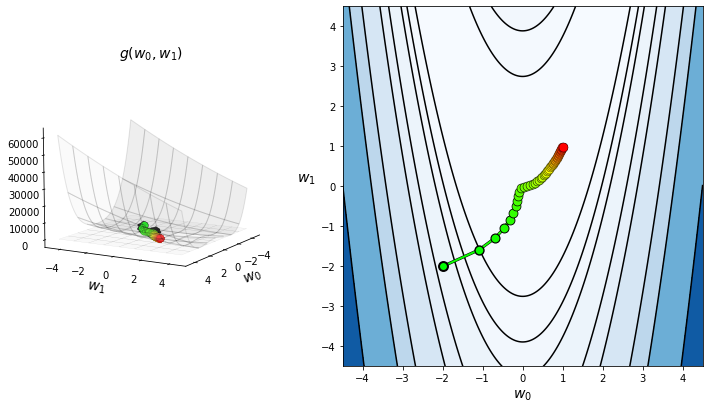

In [34]:
# from mlrefined_libraries >  math_optimization_library import 'static_plotter' function
from borrowed_code import static_plotter
static_plotter = static_plotter.Visualizer()

# convert 'w_history' from list to array for plotting convenience
w_history_case1 = np.array(w_history_case1)
w_history_case2 = np.array(w_history_case2)

# to prevent warning messages from appearing in the report
import warnings;
warnings.filterwarnings('ignore')

# to prevent long plot-related warnings that I can't unpack from outputting iteratively
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

# plot (MLR 3D function + contour plot visualization for random search optimization)
print('case 1: constant step length')
plot_case1 = static_plotter.two_input_surface_contour_plot(g, w_history_case1, view = [10, 30], xmin = -4.5, xmax = 4.5, ymin = -4.5, ymax = 4.5)
print('case 2: diminishing step length')
plot_case2 = static_plotter.two_input_surface_contour_plot(g, w_history_case2, view = [10, 30], xmin = -4.5, xmax = 4.5, ymin = -4.5, ymax = 4.5)

On the left hand side of the above plots we see a surface plot of the cost function, with the input variables `w1` and `w2` (here `w0` and `w1`) on the xy axes. On the right hand side is a contour plot of the same cost function, visualized over the same domain. The overlaid points (green -> red) show the trajectory of the input variables as they are titrated by `random_search` in search of the minimum (occuring at (1,1)). Colours are based on random search step, beginning green and terminating red.

From these plots we can see that case 2 (diminishing step length) performs better than case 1 (constant length) for this function. Both come close to the true minimum but in the same number of iterations case 2 comes closer. In the top contour plot case 1's major shortcoming is made clear. Over the first five iterations of random search, `w` is adjusted in the direction of the minimum, but on the 5th iteration it appears to get stuck, failing to take another step in the 45 remaining iterations. This indicates that on the 5th step the algorithm searches in too wide a radius for a point that further reduces cost, and as a result misses all the points nearer to the minimum. A diminishing step length seems to fix this problem. From the bottom contour plot we can see that random search appears to successfully identify input values that bring the cost function increasingly close to its minimum over all 50 iterations.

**1.5** Now we experiment with a cost function with multiple minima.

### Multiple minima {-}
Below we define the function, choose some starting parameters, and run random search.

parameters: alpha = 0.1 ; max iterations = 500 ; w = [-1, 0.5] ; # samples = 2000


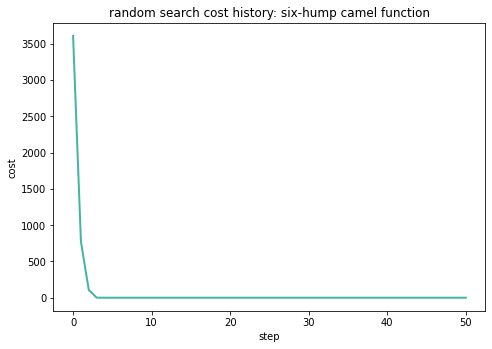

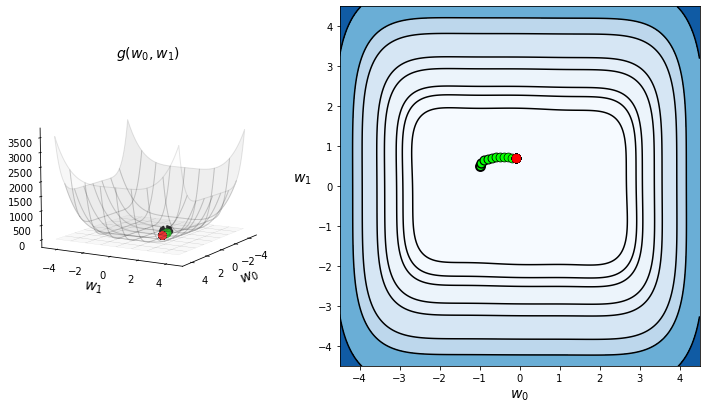

w = [-0.09069317  0.71268874]
g(w) = -1.0316256484660786 

parameters: alpha = 0.1 ; max iterations = 500 ; w = [-1, 0.1] ; # samples = 1000
w = [-0.041588319495330164, 0.7081565136811954]
g(w) = -1.02253013784593 

parameters: alpha = diminishing ; max iterations = 20 ; w = [-1.9, 0.1] ; # samples = 1000
w = [-1.6843396392720076, 0.7922419125584452]
g(w) = -0.21196065712602807


In [35]:
# define cost function
g = lambda w: (4 - 2.1*(w[0]**2) + (1/3)*(w[0]**4))*(w[0]**2) + w[0]*w[1] + (-4 + 4*(w[1]**2))*(w[1]**2)

# set random search parameters and run
alpha_choice = .1; w = [-1, .5]; num_samples = 2000; max_its = 500
print('parameters: alpha =', alpha_choice, '; max iterations =', max_its, '; w =', w, '; # samples =', num_samples) # output starting parameters
w_history, cost_history = random_search(g, alpha_choice, max_its, w, num_samples)

# plot cost history
x = range(0, len(w_history), 1)
y = cost_history

fig = plt.figure(figsize = (6, 4), frameon = 0)
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(x_case1, y_case1, color = plt_clrs[0], linewidth = 2)

ax.set_xlabel('step')
ax.set_ylabel('cost')
plt.title('random search cost history: six-hump camel function')

# contour plot
w_history = np.array(w_history)
static_plotter.two_input_surface_contour_plot(g, w_history, view = [10, 30], xmin = -4.5, xmax = 4.5, ymin = -4.5, ymax = 4.5)

# output final point reached by random search
print('w =', w_history[-1])
print('g(w) =', cost_history[-1], '\n')

# try out some other parameters
alpha_choice = .1; w = [-1, .1]; num_samples = 1000; max_its = 500
print('parameters: alpha =', alpha_choice, '; max iterations =', max_its, '; w =', w, '; # samples =', num_samples)
w_history, cost_history = random_search(g, alpha_choice, max_its, w, num_samples)
print('w =', w_history[-1])
print('g(w) =', cost_history[-1], '\n')

alpha_choice = 'diminishing'; w = [-1.9, .1]; num_samples = 1000; max_its = 20
print('parameters: alpha =', alpha_choice, '; max iterations =', max_its, '; w =', w, '; # samples =', num_samples)
w_history, cost_history = random_search(g, alpha_choice, max_its, w, num_samples)
print('w =', w_history[-1])
print('g(w) =', cost_history[-1])

plt.show()

We know based on the information we are given that in the domain $\omega1 \in [−3,3]$, $\omega2 \in [−2,2]$, `g` has 2 minima, at (0.0898,−0.7126) and (−0.0898, 0.7126). Comparing these values with the final point and cost reached by random search, we see that random search is highly dependent on its input parameters. We have the most success with the parameters: alpha_choice = .1; num_samples = 2000; max_its = 500 and a starting point of [-1, .5]. In this case (which is plotted in the surface and contour plots above), random search converges on the point (−0.0898, 0.7126). We have different degrees of success with different parameters, but in general it would seem that random search performs best with many iterations and samples, albeit at the cost of efficiency, and is more variable with respect to step length and starting point.

## **Exercise 2** *Curse of dimensionality* {-}

### The curse of dimensionality {-}

In this exercise we explore the curse of dimensionality. We start by revisiting the function in **1.2**. We define a starting point $w_0 = (1,0,...,0)$ with length $N$ equal to the dimension of the space. We use the parameters `alpha_choice` and `num_samples` chosen in **1.2** and consider, for a range of $N$, the proportion of randomly generated directions $P$ that are descent directions. 

Below we implement a portion of `random_search` from **1.2** that specifically performs the above.

In [36]:
# modified random_search function
def random_search_prop(g, alpha_choice, num_samples, dim, **kwargs):

    # for range of 'N', set 'w', run random search, and return proportion of directions that are descent
    prop_descent = np.zeros(dim) # initialize container for storing % descent values
    for N in range(1, dim + 1, 1):

        # seed the random number generator
        np.random.seed(19680801)

        w0 = np.zeros(N); w0[0] = 1    # define w based on dimension of space
        g0 = g(w0)
        
        # generate num_samples random directions and normalize
        directions = np.random.randn(len(w0), num_samples)
        directions = directions/LA.norm(directions, axis = 0)

        # from generated directions and step size, determine all candidate w values
        w_candidates = ((directions.T)*alpha_choice + w0).T # transpose 'directions' to add each to w

        # evaluate g at w_candidates
        w_candidates = map(list, w_candidates.T) # convert to list to easily iterate over
        w_candidates = list(w_candidates)
        g_candidates = np.array([g(np.array(wi)) for wi in w_candidates]) 
        
        # find proportion of g_candidates < g0 and store
        prop_descent[N - 1] = np.count_nonzero(g_candidates < g0) / num_samples

    return prop_descent

Below we plot the fraction of randomly generated directions $% of P$ that lead to descent as a function of $N$ for some different `num_samples` values.

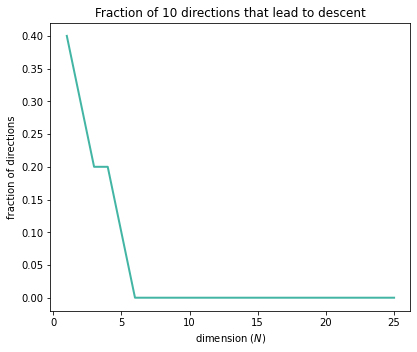

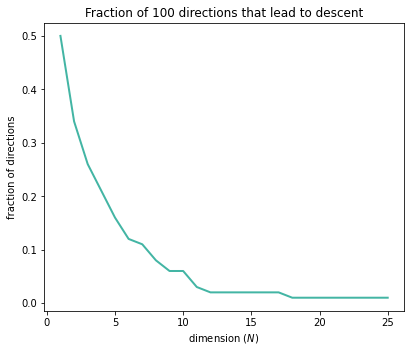

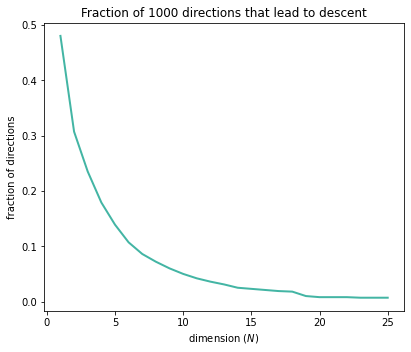

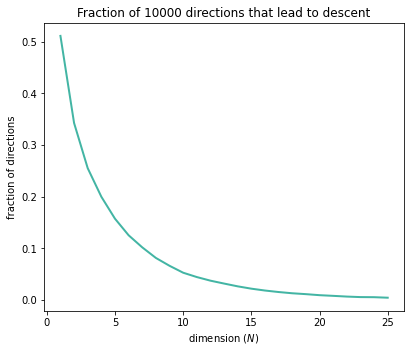

In [37]:
# cost function and parameters
g = lambda w: np.dot(w.T,w) + 2
alpha_choice = 1
dim = 25   # number of dimensions to stop iterating at

# run random_search_prop for the below `num_samples`
num_samples = 10, 100, 1000, 10000

for P in range(0, len(num_samples), 1):
    prop_descent = random_search_prop(g, alpha_choice, num_samples[P], dim)

    # plot cost history
    x = range(1, dim+1, 1)
    y = prop_descent

    fig = plt.figure(figsize = (5, 4), frameon = 0)
    ax = fig.add_axes([0, 0, 1, 1])
    ax.plot(x, y, color = plt_clrs[0], linewidth = 2)

    ax.set_xlabel('dimension ($N$)')
    ax.set_ylabel('fraction of directions')
    plt.title('Fraction of %d directions that lead to descent' % (num_samples[P]))

From the above plots the effect of dimension on random search is clear. For the parabolic cost function `g` and starting point `w0` (which lies on the bank of the parabola just next to the origin) we defined, we see the following: in one-dimensional spaces random search finds that ~50% of randomly-generated directions lead to descent, and this fraction decreases at a roughly exponential rate as dimension increases, up 25. In 25 dimensions fewer than 5% of randomly generated directions at `w0` lead to descent. This trend holds for all four simulations above, with the relationship between dimension and descent 'smoothing out' as random search samples at higher rates. This is likely a consequence of regression toward the mean, or higher sampling rates producing more reliable measurements. This analysis clearly illustrates why random search does not scale well to higher dimensions. As dimension increases, its efficiency at identifying minima decreases. 

## **Exercise 3** *Coordinate search and coordinate descent* {-}

Now we turn our attention from random search to two new algorithms.

### Coordinate search and coordinate descent {-}

**3.1** In this exercise we implement the coordinate search and coordinate descent algorithms.

Below we modify the `random_search` function implemented in **1.2** to instead run coordinate search or coordinate descent. We add the parameter `descent`, which takes a value of either 0 or 1, so that we can specify if we want to run coordinate descent instead of coordinate search. We remove the `num_samples` parameter because the number of coordinate directions is finite for finite-dimensional spaces, and we will consider them all.

In [38]:
# random search
def coordinate_search(g, alpha_choice, max_its, w, descent):
    
    # containers to store results
    w_history = []      
    cost_history = [] 

    # store initial values of 'w' and 'g'
    w_history.append(list(w))
    cost_history.append(g(w))
  
    alpha = 0
    for it in range(1, max_its + 1):
        # check if diminishing steplength rule used
        if alpha_choice == 'diminishing':
            alpha = 1/float(it)
        else:
            alpha = alpha_choice
        
        ## generate coordinate directions 
        # use identity matrix corresponding to dimension of input space (coordinate vectors are unit length so no need to normalization)
        directions = np.identity(len(w))                    # positive coordinate directions
        directions = np.append(directions, -directions, 1)  # append negative coordinate directions to array

        if descent == 0:
            ## run coordinate search: find coordinate direction that minimizes g and take a step if it reduces cost
            # find direction that minimizes cost function
            w_candidates = ((directions.T)*alpha + w).T
            w_candidates = map(list, w_candidates.T); w_candidates = list(w_candidates)
            g_candidates = np.array([g(np.array(wi)) for wi in w_candidates]) 
            min_ix = np.argmin(g_candidates) # identify index of argument (direction) that minimizes cost 
            g_min = g_candidates[min_ix]

            # store new values
            if g_min < cost_history[-1]:
                w = w_candidates[min_ix]
                w_history.append(w)
                cost_history.append(g_min)
            else:
                w_history.append(w)
                cost_history.append(cost_history[-1])

        elif descent == 1:
            ## run coordinate descent: generate permutation of 'directions' and take a step in the first that reduces cost
            # generate random permutation of directions
            np.random.seed(19680801)
            directions_perm = np.random.permutation(directions.T).T # permute directions column-wise

            # loop through directions and take a step in first one that reduces g
            for d in directions_perm.T:
                w_candidate = d*alpha + w
                if g(w_candidate) < cost_history[-1]:
                    w = w_candidate
                    w_history.append(w)
                    cost_history.append(g(w_candidate))
                
                    break
                # if final coordinate direction in permutation doesn't reduce g, maintain same 'w'
                elif np.all(d == directions_perm[:, -1]):
                    w_history.append(w)
                    cost_history.append(cost_history[-1])

    return cost_history, w_history

**3.2** In this exercise we test and compare the performance of coordinate search and coordinate descent by plotting the cost history for an example cost function.

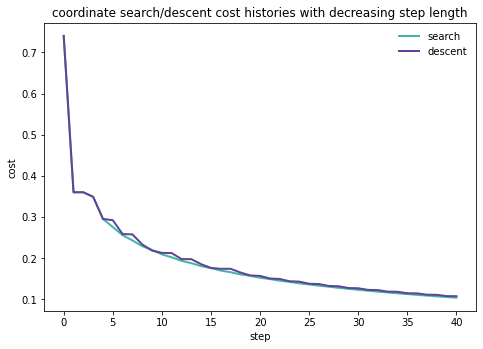

In [39]:
# define function and set parameters
g = lambda w: .26*(w[0]**2 + w[1]**2) - .48*(w[0])*(w[1])
alpha_choice = 'diminishing'; w = np.array([3,4]); max_its = 40

# run coordinate descent/search and store cost_history
cost_history_search, x = coordinate_search(g, alpha_choice, max_its, w, descent = 0)
cost_history_descemt, x = coordinate_search(g, alpha_choice, max_its, w, descent = 1)

## plot and overlay cost histories for comparison
# store data
x = list(range(0, max_its+1, 1))
y_search = cost_history_search
y_descent = cost_history_descemt

# setup plot
fig = plt.figure(figsize = (6, 4), frameon = 0)
ax = fig.add_axes([0, 0, 1, 1])

# plot
line_search = ax.plot(x, y_search, color = plt_clrs[0], linewidth = 2)
line_descent = ax.plot(x, y_descent, color = plt_clrs[1], linewidth = 2)

# add labels
ax.set_xlabel('step')
ax.set_ylabel('cost')
plt.title('coordinate search/descent cost histories with decreasing step length')

# plot legend
ax.plot(box = 0)
ax.legend([line_search, line_descent], labels = ['search', 'descent'], frameon = 0)

plt.show()

The above plot tells us that for the cost function and parameters we set, coordinate search and coordinate descent perform very similarly. The main difference appears to be that coordinate descent follows a more jagged trajectory than coordinate search in its search for the cost function minimum. We can attribute this to coordinate descent's following the first permuted coordinate direction that reduces cost, which is not necessarily always the direction that minimizes cost, which coordinate search follows. As a result coordinate search approaches the minimum more directly.

## **Exercise 4** *Gradient descent* {-}
In this exercise we implement the `gradient_descent` function that was started for us.

### Gradient descent {-}

We will need to import a couple more packages to complete this exercise.

In [40]:
import autograd.numpy as npa                    # autograd wrapped numpy, with alias 'npa'
from autograd import grad                       # import module 'grad', which will automatically differentiate and compute the gradient of 'g' at each 'w'
from autograd.misc.flatten import flatten_func  # autograd module that 'flattens' functions that take vector-valued inputs so that gradient is computed component-wise

Our starting point:

In [41]:
# gradient descent function - inputs: g (input function), alpha (steplength parameter), max_its (maximum number of iterations), w (initialization)
def gradient_descent(g,alpha,max_its,w):
    # compute gradient module using autograd
    gradient = grad(g)

    # run the gradient descent loop
    weight_history = [w]           # container for weight history
    cost_history = [g(w)]          # container for corresponding cost function history
    for k in range(max_its):
        # evaluate the gradient, store current weights and cost function value
        grad_eval = gradient(w)

        # take gradient descent step
        w = w - alpha*grad_eval
        
        # record weight and cost
        weight_history.append(w)
        cost_history.append(g(w))
    return cost_history

We modify the above to get:

In [44]:

### gradient descent function - inputs: g (input function), alpha (steplength parameter), max_its (maximum number of iterations), w (initialization)
def gradient_descent(g, alpha, max_its, w):
    
    # compute gradient - first generate flattened function for given initialization 'w', then evaluate gradient
    g_flattened, unflatten_func1, w_flattened = flatten_func(g, w) 
    dgdw = grad(g_flattened)

    ## run the gradient descent loop
    weight_history = [w]           # container for weight history
    cost_history = [g(w)]          # container for corresponding cost function history

    for it in range(max_its):
        
        # evaluate gradient for given input 'w', first converting components to floats to avoid issues with integers
        grad_eval = dgdw(w.astype(float)) 

        # take gradient descent step
        w = w - alpha*grad_eval
        
        # record weight and cost
        weight_history.append(w)
        cost_history.append(g(w))
        
    return cost_history, weight_history

We test our implementation of gradient descent using the cost function and parameters from exercise **1**.

In [45]:
# define cost function and parameters
g = lambda w: np.dot(w.T,w) + 2
alpha_choice = .3; w = np.array([3,4]); max_its = 10
cost_history, weight_history = gradient_descent(g, alpha_choice, max_its, w)
print('Gradient descent')
print('final cost: ', cost_history[-1])
print('final weight: ', weight_history[-1], '\n')

# compare outputs with corresponding outputs of 'random_search'
print('Random search')
num_samples = 1000; max_its = 20; w_history, cost_history = random_search(g, alpha_choice, max_its, w, num_samples)
print('final cost: ', cost_history[-1])
print('final weight: ', weight_history[-1])

Gradient descent
final cost:  2.000000274877907
final weight:  [0.00031457 0.00041943] 

Random search
final cost:  2.0099991076246497
final weight:  [0.00031457 0.00041943]


From the outputted information above we can see that `gradient_descent` successfully converges on the minimum of the cost function, occuring at g([0,0]) = 2. We compare this output with the corresponding output produced by `random_search`, which converges on the same minimum but requires more iterations to actually reach the minimum. This illustrates the advantage of gradient descent over random search, as well as coordinate search/descent. Of the optimization methods tested in this report, gradient decent is the most efficient at identifying minima in most cases.